In [1]:
#Pelayo Leguina - 2024

#Este script permite convertir un archivo ROOT con clases tipo TClonesArray a un DataFrame de pandas.

# Para correr este script es necesario tener instalado ROOT y pandas
# Para tener root instalado, hay que generar el env con conda. 
# Mira el archivo environment.yml para ver cómo hacerlo. Una vez tengas el env creado, activa el env y ejecuta este notebook. 
# Puedes seguir trabajando aqui o exportar el dataframe a un archivo csv para trabajar en otro lado.

import ROOT
import pandas as pd

# Definir la ruta del archivo ROOT y el nombre del árbol
ruta_archivo_root = 'DTDPGNtuple_12_4_2_Phase2Concentrator_Simulation_89.root'
nombre_arbol = 'dtNtupleProducer/DTTREE'

# Abrir el archivo ROOT
archivo = ROOT.TFile.Open(ruta_archivo_root)
if not archivo or archivo.IsZombie():
    raise FileNotFoundError(f"No se pudo abrir el archivo ROOT en {ruta_archivo_root}")

# Obtener el árbol
arbol = archivo.Get(nombre_arbol)
if not arbol:
    raise ValueError(f"No se encontró el árbol '{nombre_arbol}' en el archivo ROOT.")

# Obtener el número de eventos en el árbol
numero_eventos = arbol.GetEntries()
print(f"El árbol tiene {numero_eventos} eventos.")

# Listas de ramas
ramas_event = ['event_eventNumber']
ramas_digis_numericas = ["digi_nDigis", "digi_wheel", "digi_sector", "digi_station", 
    "digi_superLayer", "digi_layer", "digi_wire", "digi_time"]
ramas_seg_numericas = [
    "seg_nSegments", "seg_wheel", "seg_sector", "seg_station", "seg_hasPhi", 
    "seg_hasZed", "seg_posLoc_x", "seg_posLoc_y", "seg_posLoc_z", 
    "seg_dirLoc_x", "seg_dirLoc_y", "seg_dirLoc_z", "seg_posLoc_x_SL1", 
    "seg_posLoc_x_SL3", "seg_posLoc_x_midPlane", "seg_posGlb_phi", 
    "seg_posGlb_eta", "seg_dirGlb_phi", "seg_dirGlb_eta", "seg_phi_t0", 
    "seg_phi_vDrift", "seg_phi_normChi2", "seg_phi_nHits", 
    "seg_z_normChi2", "seg_z_nHits"
]
ramas_seg_arrays = [
    'seg_phiHits_pos', 'seg_phiHits_posCh', 'seg_phiHits_posErr', 
    'seg_phiHits_side', 'seg_phiHits_wire', 'seg_phiHits_wirePos', 
    'seg_phiHits_layer', 'seg_phiHits_superLayer', 'seg_phiHits_time', 
    'seg_phiHits_timeCali'
]

ramas_a_extraer = ramas_event + ramas_digis_numericas + ramas_seg_numericas + ramas_seg_arrays

# Inicializar diccionario para almacenar los datos
data = {rama: [] for rama in ramas_a_extraer}

# Iterar sobre las entradas del árbol
for evento in arbol:
    for rama in ramas_a_extraer:
        valor = getattr(evento, rama, None)
        
        if valor is None:
            data[rama].append(None)
            continue

        # Verificar si es un TClonesArray
        if hasattr(valor, 'GetEntriesFast'):
            valores = []
            for i in range(valor.GetEntriesFast()):
                elemento = valor.At(i)
                if hasattr(elemento, '__len__'):  # Si es vectorizable
                    valores.append([x for x in elemento])
                else:
                    valores.append(elemento)
            data[rama].append(valores)
        elif isinstance(valor, ROOT.TVectorF) or isinstance(valor, ROOT.TVectorD):
            # Manejar TVectorT como TVectorF (float) o TVectorD (double)
            data[rama].append([valor[i] for i in range(valor.GetNrows())])
        elif isinstance(valor, (int, float)):
            # Escalar simple
            data[rama].append(valor)
        else:
            try:
                # Intentar convertir a lista si es iterable
                data[rama].append(list(valor))
            except TypeError:
                data[rama].append(valor)

# Cerrar el archivo ROOT
archivo.Close()

# Verificar que todas las ramas tienen la misma longitud
longitudes = {rama: len(val) for rama, val in data.items()}
print("Longitud de cada rama:")
for rama, longitud in longitudes.items():
    print(f"{rama}: {longitud}")

# Convertir a DataFrame
try:
    df = pd.DataFrame(data)
except ValueError as e:
    print("Error al crear el DataFrame:", e)
    for rama, longitud in longitudes.items():
        print(f"{rama}: {longitud}")
    raise

# Mostrar una vista previa del DataFrame
print("\nVista previa del DataFrame:")
print(df.head())

# Contar los hits en las ramas tipo array
for rama in ramas_seg_arrays:
    if rama in df.columns:
        df[f'{rama}_count'] = df[rama].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Mostrar conteos
for rama in ramas_seg_arrays:
    if f'{rama}_count' in df.columns:
        print(f"\nNúmero de hits por evento en '{rama}':")
        print(df[f'{rama}_count'].head())

# Guardar el DataFrame en un archivo CSV
df.to_csv('data.csv', index=False)
print('Data saved in data.csv')

#Ahora ya puedes trabajar con el df para generar las entradas/verdades de tu modelo de ML
#Siempre asegurate de preprocesar el df, rellenar los NaNs, normalizar los datos, etc.

#Recuerda que deberíamos filtrar los digis pertenecientes a la SL2 (no trabajamos en esa dimension)
#Lo mismo para los segmentos que no tienen hits en phi (son segmentos de la SL2 y tambien tenemos que cargarnoslos)
# Suerte! :)

El árbol tiene 439 eventos.
Longitud de cada rama:
event_eventNumber: 439
digi_nDigis: 439
digi_wheel: 439
digi_sector: 439
digi_station: 439
digi_superLayer: 439
digi_layer: 439
digi_wire: 439
digi_time: 439
seg_nSegments: 439
seg_wheel: 439
seg_sector: 439
seg_station: 439
seg_hasPhi: 439
seg_hasZed: 439
seg_posLoc_x: 439
seg_posLoc_y: 439
seg_posLoc_z: 439
seg_dirLoc_x: 439
seg_dirLoc_y: 439
seg_dirLoc_z: 439
seg_posLoc_x_SL1: 439
seg_posLoc_x_SL3: 439
seg_posLoc_x_midPlane: 439
seg_posGlb_phi: 439
seg_posGlb_eta: 439
seg_dirGlb_phi: 439
seg_dirGlb_eta: 439
seg_phi_t0: 439
seg_phi_vDrift: 439
seg_phi_normChi2: 439
seg_phi_nHits: 439
seg_z_normChi2: 439
seg_z_nHits: 439
seg_phiHits_pos: 439
seg_phiHits_posCh: 439
seg_phiHits_posErr: 439
seg_phiHits_side: 439
seg_phiHits_wire: 439
seg_phiHits_wirePos: 439
seg_phiHits_layer: 439
seg_phiHits_superLayer: 439
seg_phiHits_time: 439
seg_phiHits_timeCali: 439

Vista previa del DataFrame:
   event_eventNumber  digi_nDigis  \
0              52

In [2]:
from newGeo.dtGeometry import *
from itertools import chain
import logging

geometry_xml_path = "newGeo/DTGeometry.xml"


# Parse DT Geometry XML
print("\nParsing DT Geometry XML...")
df_geometry = parse_dtgeometry_xml(geometry_xml_path)

def create_wire_position_mapping(df_geometry):
    mapping = {}
    for idx, row in df_geometry.iterrows():
        chamber_rawId = row['Chamber_rawId']
        superLayerNumber = row['SuperLayerNumber']
        layerNumber = row['LayerNumber']
        channels_total = row['Channels_total']
        wireFirst = row['WirePositions_FirstWire']
        wireLast = row['WirePositions_LastWire']
        # Create Wire object to get positions
        wire_obj = Wire(wireFirst, wireLast, channels_total, row['Layer_Local_z'])
        # Map wire numbers to positions
        for wire_idx, x_pos in enumerate(wire_obj.positions):
            wire_number = wire_idx + 1  # Assuming wire numbers start from 1
            key = (chamber_rawId, superLayerNumber, layerNumber, wire_number)
            mapping[key] = x_pos
    return mapping

def explode_dataframe(df, list_columns):
    """Explota columnas con listas en filas separadas."""
    # Repetir índices según la longitud de las listas
    lengths = df[list_columns[0]].apply(len)
    idx = df.index.repeat(lengths)

    # Explotar las columnas de listas
    exploded_data = {col: list(chain.from_iterable(df[col])) for col in list_columns}

    # Agregar las columnas que no son listas
    exploded_df = pd.DataFrame(exploded_data, index=idx)
    non_list_columns = df.columns.difference(list_columns)
    for col in non_list_columns:
        exploded_df[col] = df[col].repeat(lengths)

    return exploded_df.reset_index(drop=True)

def add_chamber_rawId_to_digis(df):
    """Agrega la columna chamber_rawId basada en wheel, station y sector."""
    chamber_rawIds = []
    for idx, row in df.iterrows():
        try:
            rawId = get_rawId(row['digi_wheel'], row['digi_station'], row['digi_sector'])
        except ValueError as e:
            logging.error(f"Error al calcular rawId en el índice {idx}: {e}")
            rawId = None
        chamber_rawIds.append(rawId)
    df['digi_chamber_rawId'] = chamber_rawIds
    return df

def map_digi_wires_to_positions(df, wire_position_mapping):
    """Mapea los wires a sus posiciones en x usando wire_position_mapping."""
    x_positions = []
    for idx, row in df.iterrows():
        key = (row['digi_chamber_rawId'], row['digi_superLayer'], row['digi_layer'], row['digi_wire'])
        x_pos = wire_position_mapping.get(key, None)  # Por defecto, None si no se encuentra la clave
        x_positions.append(x_pos)
    df['digi_x_pos'] = x_positions
    return df

def reconstruct_dataframe(df_original, df_flattened, list_columns, extra_columns):
    """
    Reconstruye el DataFrame original, agrupando las columnas calculadas en listas.

    Args:
    - df_original: DataFrame original con listas.
    - df_flattened: DataFrame aplanado después de las explosiones y cálculos.
    - list_columns: Columnas que originalmente estaban en formato de lista.
    - extra_columns: Nuevas columnas a agregar al DataFrame.

    Returns:
    - DataFrame reconstruido con las columnas adicionales.
    """
    # Crear índice auxiliar para asociar filas a las originales
    df_flattened["original_index"] = df_original.index.repeat(
        df_original[list_columns[0]].apply(len)
    )

    # Agrupar filas aplanadas según el índice original
    grouped = df_flattened.groupby("original_index")

    # Agregar de vuelta las columnas originales y las nuevas
    for col in list_columns + extra_columns:
        df_original[col] = grouped[col].apply(list).reindex(df_original.index).tolist()

    return df_original

wire_position_mapping = create_wire_position_mapping(df_geometry)

# Columnas con valores en listas
list_columns = ['digi_wheel', 'digi_sector', 'digi_station', 'digi_superLayer', 'digi_layer', 'digi_wire']

# Explotar el DataFrame para trabajar con cada digi individualmente
df_flattened = explode_dataframe(df, list_columns)

# Agregar la columna chamber_rawId
df_flattened = add_chamber_rawId_to_digis(df_flattened)

# Calcular las posiciones de los wires
df_flattened = map_digi_wires_to_positions(df_flattened, wire_position_mapping)

# Reconstruir el DataFrame original con la nueva columna
df = reconstruct_dataframe(df, df_flattened, list_columns, ['digi_x_pos'])

# Reordenar columnas para que digi_x_pos aparezca después de digi_wire
columns = df.columns.tolist()
digi_wire_index = columns.index('digi_wire')
columns.insert(digi_wire_index + 1, columns.pop(columns.index('digi_x_pos')))
df = df[columns]

# Mostrar el DataFrame final 
#print(df.head())


Parsing DT Geometry XML...


In [3]:
# Ramas relacionadas con 'digis'
ramas_digis = [
    "event_eventNumber",
    "digi_nDigis", "digi_wheel", "digi_sector", "digi_station", 
    "digi_superLayer", "digi_layer", "digi_wire", "digi_time"
]

# Ramas relacionadas con 'segments' (seg)
ramas_segments = [
    "event_eventNumber",
    "seg_nSegments",
    "seg_wheel",
    "seg_sector",
    "seg_station",
    "seg_hasPhi",
    "seg_hasZed",
    "seg_posLoc_x",
    "seg_posLoc_y",
    "seg_posLoc_z",
    "seg_dirLoc_x",
    "seg_dirLoc_y",
    "seg_dirLoc_z",
    "seg_posLoc_x_SL1",
    "seg_posLoc_x_SL3",
    "seg_posLoc_x_midPlane",
    "seg_posGlb_phi",
    "seg_posGlb_eta",
    "seg_dirGlb_phi",
    "seg_dirGlb_eta",
    "seg_phi_t0",
    "seg_phi_vDrift",
    "seg_phi_normChi2",
    "seg_phi_nHits",
    "seg_z_normChi2",
    "seg_z_nHits",
    "seg_phiHits_wire",
    "seg_phiHits_layer",
    "seg_phiHits_superLayer"
]

# Combinar todas las ramas a extraer
ramas_a_extraer = ramas_digis + ramas_segments

In [4]:
# Extraer las ramas relacionadas con 'digis' en un DataFrame de pandas
df_digis = df[ramas_digis]

# Extraer las ramas relacionadas con 'segments' en otro DataFrame de pandas
df_segments = df[ramas_segments]

In [8]:
# Función para convertir Awkward Arrays a listas de Python
def convertir_a_lista(x):
    if isinstance(x, (list, tuple, np.ndarray)):
        return list(x)
    return [x]  # En caso de que sea un valor escalar, lo convertimos en lista

# Aplicar la conversión a todas las columnas de 'digis' que son listas ( excepto 'event_eventNumber' )  

for col in ramas_digis:
    df_digis[col] = df_digis[col].apply(convertir_a_lista)

for col in ramas_segments:
    df_segments.loc[:,col] = df_segments[col].apply(convertir_a_lista)

### Primero manupulo los digis

In [9]:
# Definir las columnas relacionadas con 'digis' que serán aplanadas
columns_to_explode_digis = ['digi_superLayer', 'digi_layer', 'digi_wire', 'digi_time', 'digi_wheel', 'digi_sector', 'digi_station']

# Función para verificar si todas las listas tienen la misma longitud en una fila
def verificar_longitudes(row, cols):
    lengths = [len(row[col]) for col in cols]
    return len(set(lengths)) == 1  # True si todas las longitudes son iguales

# Aplicar la función a cada fila
# Asignar la columna 'same_length' usando .loc
df_digis.loc[:, 'same_length'] = df_digis.apply(lambda row: verificar_longitudes(row, columns_to_explode_digis), axis=1)

# Verificar cuántas filas cumplen la condición
print("Número de filas con listas de la misma longitud en 'digis':")
print(df_digis['same_length'].value_counts())

# Filtrar solo las filas que cumplen la condición
df_digis = df_digis[df_digis['same_length']]

# Eliminar la columna auxiliar
df_digis = df_digis.drop(columns=['same_length'])


Número de filas con listas de la misma longitud en 'digis':
same_length
True    439
Name: count, dtype: int64


In [10]:
# ahora vamos a aplanar las columnas de 'digis' que contienen listas
columns_to_explode_digis = [
    'digi_superLayer', 'digi_layer', 'digi_wire', 
    'digi_time', 'digi_wheel', 'digi_sector', 'digi_station'
]

df_digis_exploded = df_digis.explode(columns_to_explode_digis)

# Renombrar las columnas a nombres más cortos
df_digis_exploded = df_digis_exploded.rename(columns={
    "event_eventNumber": "eventNumber",
    "digi_superLayer": "superLayer",
    "digi_layer": "layer",
    "digi_wire": "wire",
    "digi_time": "time",
    "digi_wheel": "wheel",
    "digi_sector": "sector",
    "digi_station": "station"
})

# Convertir 'event_eventNumber' a entero, ya que antes era una lista
df_digis_exploded['eventNumber'] = df_digis_exploded['eventNumber'].apply(lambda x: x if isinstance(x, (int, str)) else x[0])

# Eliminar la columna 'digi_nDigis' ya que no es necesaria, puesto que cuenta el numero de digis en cada evento, no de cada estación
df_digis_exploded = df_digis_exploded.drop(columns=['digi_nDigis'])
# ELiminamos los digis de la superLayer 2, ya que no son necesarios y pueden influir en los resultados
df_digis_exploded = df_digis_exploded[df_digis_exploded['superLayer'] != 2]
#print("Preview of 'df_digis_exploded':")
#display(df_digis_exploded.head())

In [11]:
# Ahora vamos a agrupar los digis por evento y estación
df_digis_grouped = df_digis_exploded.groupby(
    ['eventNumber', 'wheel', 'sector', 'station']
).agg({
    'superLayer': list,
    'layer': list,
    'wire': list,
    'time': list
}).reset_index()

df_digis_grouped['n_digis'] = df_digis_grouped['wire'].apply(len)

# Mostrar una vista previa después de aplanar
tamaño_bytes = df_digis_grouped.memory_usage(deep=True).sum()
print(f"Tamaño del DataFrame en bytes: {tamaño_bytes}")
#df_digis_grouped.head()

Tamaño del DataFrame en bytes: 3583612


### Para hacer los grafos

In [12]:
# Eliminar las columnas 'time' no nos hacen falta para los nodos
df_digis_exploded_graph = df_digis_exploded.drop(columns=['time'])

#agrupar digis para hacer los grafos
df_digis_nodos = df_digis_exploded_graph.groupby(
    ['eventNumber', 'wheel', 'sector', 'station','superLayer']
).agg({
    'wire': list,
    'layer': list
}).reset_index()

#ESTO DE A CONTINUACION NO SE SI ES NECESARIO
# Si la lista de wire tiene menos de 4 elementos quitamos esa fila pues es ruido
# Filtrar las filas donde la longitud de la lista en 'wire' sea menor que 4
#df_digis_nodos = df_digis_nodos[df_digis_nodos['wire'].apply(len) >= 4]
#df_digis_nodos.head()

Para verlo hecho con networkx mirar grafos .ipynb

In [13]:
#Con torch
import torch
from torch_geometric.data import Data
import itertools

# Función para construir el grafo
def construir_grafo_pyg(row):
    wires = row['wire']  
    layers = row['layer']  

    # Crear nodos como pares (wire, layer)
    nodos = [(wires[i], layers[i]) for i in range(len(wires))]

    # Crear mapa de nodos a indices
    nodo_indices = {nodo: idx for idx, nodo in enumerate(nodos)}

    # Generar aristas
    edge_index = []
    for i, j in itertools.combinations(range(len(nodos)), 2):
        wire_i, layer_i = nodos[i]
        wire_j, layer_j = nodos[j]

        if abs(layer_i - layer_j) == 1 and abs(wire_i - wire_j) <= 1:
            edge_index.append((nodo_indices[nodos[i]], nodo_indices[nodos[j]]))

    # Convertir a tensores de PyTorch
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.tensor([[wire, layer] for wire, layer in nodos], dtype=torch.float)

    return Data(x=x, edge_index=edge_index)

# Ejemplo con la primera fila del dataframe
ejemplo_grafo = construir_grafo_pyg(df_digis_nodos.iloc[0])
print(ejemplo_grafo)

# Imprimir aristas en forma de pares de nodos
edge_index = ejemplo_grafo.edge_index
aristas = edge_index.t().tolist()  # Convertir a lista de pares
print("Aristas:", aristas)


Data(x=[4, 2], edge_index=[2, 3])
Aristas: [[0, 1], [1, 2], [2, 3]]


### Ahora manipulo los segments

In [14]:
# Se construyen ahora la verdades con la parte de segments
# En concreto nos interesan las columnas seg_phiHits_wire y seg_phiHits_superlayer
# Creamos los grafos de la misma manera, primero aplanamos los datos

# Eliminar columnas de segmentos con las que no vamos a trabajar (todas menos 'event_eventNumber', 'seg_wheel', 'seg_sector', 'seg_station')
#Esto es porque de momento queremos solo predecir si hay o no segmentos en una estación, no cuantos ni su posición.

columnas_a_eliminar = [col for col in df_segments.columns if col not in ['event_eventNumber', 'seg_wheel', 'seg_sector', 'seg_station',"seg_phiHits_wire","seg_phiHits_layer","seg_phiHits_superLayer"]]

df_segments_filtered = df_segments.drop(columns=columnas_a_eliminar)

# Nos aseguramos de que 'event_eventNumber' sea un escalar, ya que antes convertimos todas las columnas a listas
df_segments_filtered['event_eventNumber'] = df_segments['event_eventNumber'].str[0]

# ahora vamos a aplanar las columnas de 'digis' que contienen listas
columns_to_explode_segments = [
    "seg_phiHits_superLayer", "seg_phiHits_layer", "seg_phiHits_wire", 
    'seg_wheel', 'seg_sector', 'seg_station'
]


df_segments_exploded = df_segments_filtered.explode(columns_to_explode_segments)

# Renombrar las columnas a nombres más cortos
df_segments_exploded = df_segments_exploded.rename(columns={
    "event_eventNumber": "eventNumber",
    "seg_phiHits_superLayer": "superLayer",
    "seg_phiHits_layer": "layer",
    "seg_phiHits_wire": "wire",
    'seg_wheel': "wheel",
    'seg_sector': "sector",
    'seg_station': "station"
})

# Nos aseguramos de que 'event_eventNumber' sea un escalar, ya que antes convertimos todas las columnas a listas
df_segments_exploded['event_eventNumber'] = df_segments['event_eventNumber'].str[0]

df_segments_exploded.head()

,eventNumber,wheel,sector,station,wire,layer,superLayer,event_eventNumber
0,52244,-1,1,1,[],[],[],52244
0,52244,0,5,1,"[33.0, 34.0, 33.0, 34.0, 34.0, 34.0, 34.0]","[1.0, 2.0, 3.0, 4.0, 1.0, 2.0, 4.0]","[1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 3.0]",52244
0,52244,0,5,1,"[33.0, 35.0, 37.0, 38.0]","[1.0, 4.0, 1.0, 3.0]","[1.0, 1.0, 3.0, 3.0]",52244
0,52244,0,5,1,"[33.0, 34.0, 34.0, 35.0]","[1.0, 1.0, 3.0, 4.0]","[1.0, 3.0, 3.0, 3.0]",52244
0,52244,0,5,1,"[34.0, 35.0, 34.0, 37.0]","[1.0, 2.0, 3.0, 1.0]","[1.0, 1.0, 1.0, 3.0]",52244


In [15]:
# hay que eliminar las filas que tienen listas vacias en wire, layer y superlayer puesto que estas pertenecen a la superlayer 2
# Identificar y eliminar filas donde col2 (u otra columna) tiene listas vacías
columnas_a_revisar = ["wire", 'layer', 'superLayer']  # Lista de columnas que queremos revisar
df_segments_exploded_limpio = df_segments_exploded[~df_segments_exploded[columnas_a_revisar]
    .apply(lambda col: col.apply(lambda x: isinstance(x, list) and len(x) == 0))
    .any(axis=1)
] 

# Función para convertir los números de una lista a enteros
def convertir_a_enteros(lista):
    return [int(x) if isinstance(x, (float, int)) else x for x in lista]

# Aplicar la conversión solo a las columnas que contienen listas
df_segments_exploded_limpio.loc[:, "wire"] = df_segments_exploded_limpio["wire"].apply(convertir_a_enteros)
df_segments_exploded_limpio.loc[:, "layer"] = df_segments_exploded_limpio["layer"].apply(convertir_a_enteros)
df_segments_exploded_limpio.loc[:, "superLayer"] = df_segments_exploded_limpio["superLayer"].apply(convertir_a_enteros)

#volvemos a explotar
df_segments_exploded_2 = df_segments_exploded_limpio.explode(columnas_a_revisar)

# Ahora vamos a agrupar los digis por evento y estación
df_segments_nodos = df_segments_exploded_2.groupby(
    ['eventNumber', 'wheel', 'sector', 'station', 'superLayer']
).agg({
    'layer': list,
    'wire': list,
}).reset_index()

df_segments_nodos.head()

,eventNumber,wheel,sector,station,superLayer,layer,wire
0,52242,-2,4,1,1,"[1, 2, 3, 4]","[39, 39, 38, 39]"
1,52242,-1,12,2,1,"[1, 2, 3, 4]","[8, 9, 8, 9]"
2,52242,-1,12,2,3,"[1, 2, 3, 4]","[9, 10, 9, 10]"
3,52242,1,2,1,1,"[1, 2, 3, 4]","[16, 17, 17, 17]"
4,52242,1,2,1,3,"[1, 2, 3, 4]","[20, 20, 20, 20]"


In [16]:
# Creamos los grafos con torch, usando la funcion creada antes
# Ejemplo con la primera fila del dataframe
ejemplo_grafo = construir_grafo_pyg(df_segments_nodos.iloc[0])

print(ejemplo_grafo)

# Imprimir aristas en forma de pares de nodos
edge_index = ejemplo_grafo.edge_index
aristas = edge_index.t().tolist()  # Convertir a lista de pares
print("Aristas:", aristas)


Data(x=[4, 2], edge_index=[2, 3])
Aristas: [[0, 1], [1, 2], [2, 3]]


### Creo nuevos grafos a los que le incluyo la verdad

In [17]:
from itertools import zip_longest
#Lo mismo pero optimizado
df1 = df_digis_nodos
df2 = df_segments_nodos

# Columnas a usar para la comparación de correspondencia (excluyendo 'wire' y 'layer')
comparison_columns = ["eventNumber", "wheel", "sector", "station", "superLayer"]

# Unir los DataFrames usando las columnas relevantes
merged_df = pd.merge(df1, df2, on=comparison_columns, suffixes=('_df1', '_df2'))

# Función para comparar listas con manejo de longitudes distintas
def compare_lists(list1, list2):
    return [x == y if x is not None and y is not None else False for x, y in zip_longest(list1, list2)]

# Aplicar la comparación de listas a las columnas 'wire' y 'layer'
merged_df['wire_comparison'] = merged_df.apply(lambda row: compare_lists(row['wire_df1'], row['wire_df2']), axis=1)
merged_df['layer_comparison'] = merged_df.apply(lambda row: compare_lists(row['layer_df1'], row['layer_df2']), axis=1)

# Seleccionar solo las columnas de interés
df_verdad = merged_df[['wire_comparison', 'layer_comparison']]

# Mostrar el resultado
print(df_verdad)


                       wire_comparison                   layer_comparison
0             [True, True, True, True]           [True, True, True, True]
1             [True, True, True, True]           [True, True, True, True]
2             [True, True, True, True]           [True, True, True, True]
3             [True, True, True, True]           [True, True, True, True]
4             [True, True, True, True]           [True, True, True, True]
...                                ...                                ...
6766                [True, True, True]                 [True, True, True]
6767          [True, True, True, True]           [True, True, True, True]
6768  [True, True, True, False, False]  [True, True, False, False, False]
6769                            [True]                             [True]
6770         [True, True, True, False]          [True, True, True, False]

[6771 rows x 2 columns]


In [ ]:
# Funcion para construir el grafo y agregar las etiquetas de la verdad
def construir_grafo_pyg_con_etiquetas(row, df_verdad):
    wires = row['wire']  
    layers = row['layer']  

    # Crear nodos como pares (wire, layer)
    nodos = [(wires[i], layers[i]) for i in range(len(wires))]

    # Crear mapa de nodos a indices
    nodo_indices = {nodo: idx for idx, nodo in enumerate(nodos)}

    # Generar aristas
    edge_index = []
    for i, j in itertools.combinations(range(len(nodos)), 2):
        wire_i, layer_i = nodos[i]
        wire_j, layer_j = nodos[j]

        # Conectar nodos solo si estan en capas consecutivas y son cercanos en los wires
        if abs(layer_i - layer_j) == 1 and abs(wire_i - wire_j) <= 1:
            edge_index.append((nodo_indices[nodos[i]], nodo_indices[nodos[j]]))

    # Convertir a tensores de PyTorch
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.tensor([[wire, layer] for wire, layer in nodos], dtype=torch.float)

    # Ahora asignamos las etiquetas de verdad según df_verdad
    # Asegurémonos de que df_verdad tiene el mismo número de nodos que el grafo
    verdad_etiquetas = []
    for i in range(len(nodos)):
        # Asignamos la etiqueta de la verdad a cada nodo basado en df_verdad
        # Usamos el índice 'i' para acceder a las columnas de 'wire' y 'layer' del df_verdad
        # Aquí asumo que las columnas 'wire' y 'layer' en df_verdad están relacionadas con los nodos
        etiqueta = 1 if df_verdad['wire_comparison'][i] and df_verdad['layer_comparison'][i] else 0
        verdad_etiquetas.append(etiqueta)

    # Convertir las etiquetas de verdad a un tensor de PyTorch
    y = torch.tensor(verdad_etiquetas, dtype=torch.long)

    # Retornar el objeto Data con las características de los nodos (x), las conexiones (edge_index), y las etiquetas de verdad (y)
    return Data(x=x, edge_index=edge_index, y=y)

# Construir el grafo con las etiquetas de la verdad
grafo_verdad = construir_grafo_pyg_con_etiquetas(df_digis_nodos.iloc[0], df_verdad.iloc[0])

# Imprimir el grafo resultante
print(grafo_verdad)

# Imprimir las aristas del grafo
edge_index = grafo_verdad.edge_index
aristas = edge_index.t().tolist()  # Convertir a lista de pares
print("Aristas:", aristas)

# Imprimir las etiquetas de la verdad
print("Verdad etiquetas:", grafo_verdad.y)


Data(x=[4, 2], edge_index=[2, 3], y=[4])
Aristas: [[0, 1], [1, 2], [2, 3]]
Verdad etiquetas: tensor([1, 1, 1, 1])


In [ ]:
#CREAR DATASET

from torch_geometric.data import Data, Dataset, DataLoader

# Ahora, crearemos un dataset.
class MuonTrajectoryDataset(Dataset):
    def __init__(self, df_digis_nodos, df_verdad, transform=None):
        self.df_digis_nodos = df_digis_nodos
        self.df_verdad = df_verdad
        self.transform = transform  # Atributo transform, por si se desea aplicar alguna transformación

    def len(self):
        # Aquí devolvemos el tamaño del dataset, que es el número de filas en df_digis_nodos
        return len(self.df_digis_nodos)

    def get(self, idx):
        # Obtener la fila correspondiente al índice
        row = self.df_digis_nodos.iloc[idx]
        # Construir el grafo con la fila actual y las etiquetas de la verdad
        data = construir_grafo_pyg_con_etiquetas(row, self.df_verdad)

        # Si se define una transformación, aplicarla a los datos
        if self.transform:
            data = self.transform(data)

        return data
    
    def indices(self):
        # Implementar indices() para devolver el rango de índices
        return range(len(self.df_digis_nodos))

# Crear el dataset
dataset = MuonTrajectoryDataset(df_digis_nodos, df_verdad)

# Verificar el tamaño del dataset
print(f"Tamaño del dataset: {len(dataset)}")

# Crear un DataLoader para manejar los lotes
data_loader = DataLoader(dataset, batch_size=2, shuffle=True)

# Filtrar grafos sin aristas
# Filtrar grafos sin aristas
valid_dataset = [data for data in dataset if data.edge_index.numel() > 0]

print(f"Grafos válidos: {len(valid_dataset)} de {len(dataset)}")

# Ejemplo de cómo acceder a los datos
#for data in data_loader:
#    print(data)

Tamaño del dataset: 10060


/home/blanca_belmonte/miniconda3/envs/jupyter_ml_env/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Grafos válidos: 8092 de 10060


### Graph Neural Network

In [19]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        # Primera capa de convolución de grafo
        self.conv1 = GCNConv(input_dim, hidden_dim)
        # Segunda capa de convolución de grafo
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        # Capa final (clasificación)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        # Pasamos las características de entrada y las conexiones del grafo
        x, edge_index = data.x, data.edge_index

        # Primera capa con ReLU
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # Segunda capa con ReLU
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Capa totalmente conectada
        x = self.fc(x)

        # Predicción por nodo (usamos softmax en problemas de clasificación)
        return F.log_softmax(x, dim=1)

# Definir los hiperparámetros
input_dim = 2  # wire y layer como características
hidden_dim = 16  # Número de dimensiones ocultas
output_dim = 2  # Dos clases (parte de la trayectoria: 1, no parte: 0)

# Crear una instancia del modelo
model = GCN(input_dim, hidden_dim, output_dim)

# Imprimir el modelo
print(model)


GCN(
  (conv1): GCNConv(2, 16)
  (conv2): GCNConv(16, 16)
  (fc): Linear(in_features=16, out_features=2, bias=True)
)


In [20]:
from torch.utils.data import random_split

# Proporción de datos para entrenamiento
train_ratio = 0.8  # 80% para entrenamiento, 20% para prueba

# Tamaños de los conjuntos
train_size = int(len(valid_dataset) * train_ratio)
test_size = len(valid_dataset) - train_size

# Dividir el dataset
train_dataset, test_dataset = random_split(valid_dataset, [train_size, test_size])

# Crear DataLoaders para manejar lotes
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# Verificar tamaños
print(f"Tamaño del conjunto de entrenamiento: {len(train_dataset)}")
print(f"Tamaño del conjunto de prueba: {len(test_dataset)}")


Tamaño del conjunto de entrenamiento: 6473
Tamaño del conjunto de prueba: 1619


In [21]:
from torch_geometric.loader import DataLoader
from torch.optim import Adam

# Configurar el optimizador y la función de pérdida
optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

epochs = 4

# Entrenamiento del modelo
def train():
    model.train()
    losses = [] # para graficar la pérdida
    accuracies = [] # para graficar la precision del modelo
    
    for epoch in range(epochs):  # Número de épocas
        total_loss = 0
        correct = 0
        total = 0
        for data in train_loader:
            optimizer.zero_grad()  # Limpiar gradientes

            # Pasar datos al modelo
            out = model(data)

            # Calcular la pérdida
            loss = loss_fn(out, data.y)
            total_loss += loss.item()

            # Retropropagación
            loss.backward()
            optimizer.step()
            
            # Calcular precisión para esta iteración
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.y.size(0)

        avg_loss = total_loss / len(train_loader)  # Pérdida promedio por época
        accuracy = correct / total  # Precisión de la época
        losses.append(avg_loss)
        accuracies.append(accuracy)    
        print(f"Época {epoch+1}: Pérdida = {avg_loss:.4f}, Precisión = {accuracy:.4f}")
    return losses, accuracies
# Ejecutar el entrenamiento
losses, accuracies = train()


Época 1: Pérdida = 0.0020, Precisión = 0.9992
Época 2: Pérdida = 0.0001, Precisión = 1.0000
Época 3: Pérdida = 0.0001, Precisión = 1.0000
Época 4: Pérdida = 0.0001, Precisión = 1.0000


In [22]:
def test(loader):
    model.eval()
    correct = 0
    total = 0

    for data in loader:
        out = model(data)
        pred = out.argmax(dim=1)  # Clase con mayor probabilidad
        correct += (pred == data.y).sum().item()
        total += data.y.size(0)

    print(f"Accuracy: {correct / total:.4f}")

# Evaluar el modelo
test(test_loader)


Accuracy: 1.0000


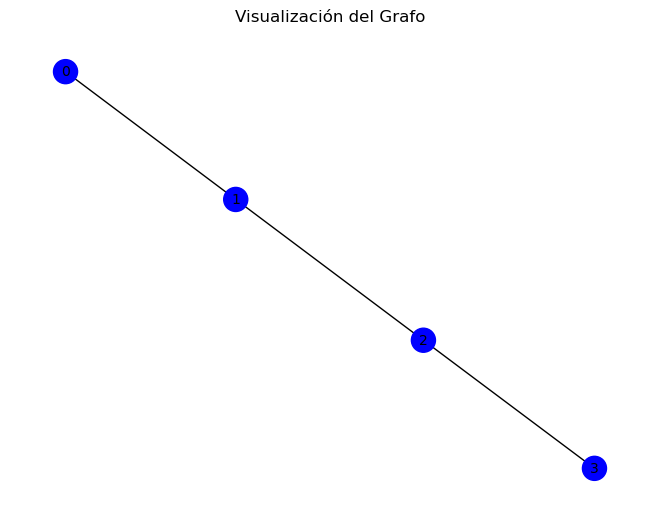

In [23]:
#visualizacion de uno de los grafos
import networkx as nx

def visualizar_grafo(data, pred=None):
    # Crear el grafo con NetworkX
    G = nx.Graph()
    edge_index = data.edge_index.numpy().T  # Convertir aristas a numpy
    G.add_edges_from(edge_index)

    # Asignar colores según etiquetas o predicciones
    if pred is None:
        labels = data.y.numpy()  # Etiquetas verdaderas
    else:
        labels = pred.numpy()  # Predicciones del modelo

    colors = ['blue' if label == 1 else 'red' for label in labels]

    # Dibujar el grafo
    pos = nx.spring_layout(G)  # Layout del grafo
    nx.draw(G, pos, node_color=colors, with_labels=True, node_size=300, font_size=10)
    plt.title("Visualización del Grafo")
    plt.show()

# Visualizar un ejemplo del dataset
ejemplo_data = dataset[0]  # Seleccionar un grafo del dataset
predicciones = model(ejemplo_data).argmax(dim=1)  # Obtener predicciones
visualizar_grafo(ejemplo_data, pred=predicciones)


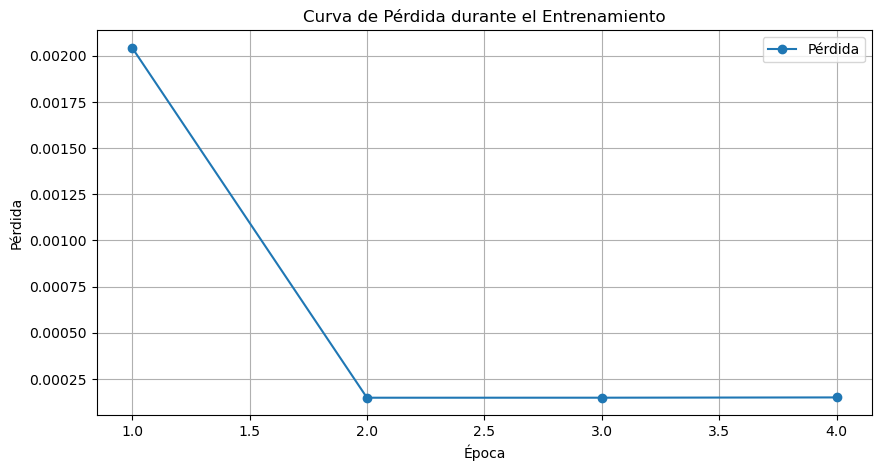

In [24]:
# Curva de Pérdida
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(losses) + 1), losses, marker='o', label='Pérdida')
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Curva de Pérdida durante el Entrenamiento")
plt.grid()
plt.legend()
plt.show()

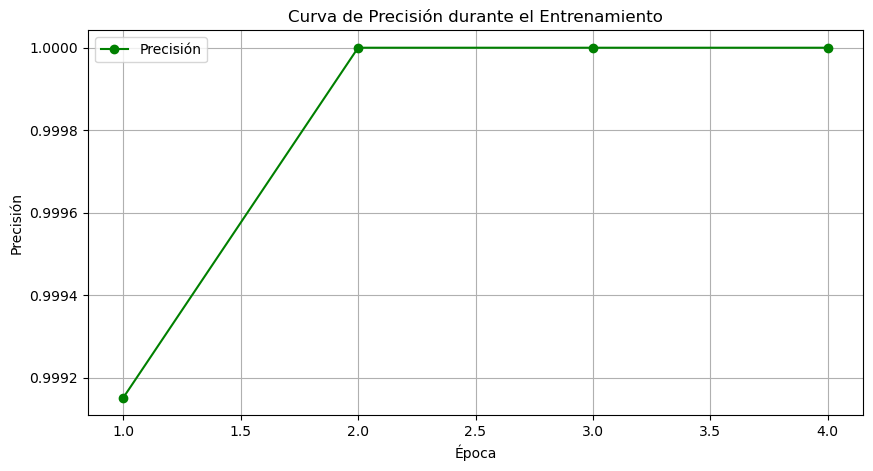

In [25]:
# Curva de Precisión
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', color='green', label='Precisión')
plt.xlabel("Época")
plt.ylabel("Precisión")
plt.title("Curva de Precisión durante el Entrenamiento")
plt.grid()
plt.legend()
plt.show()

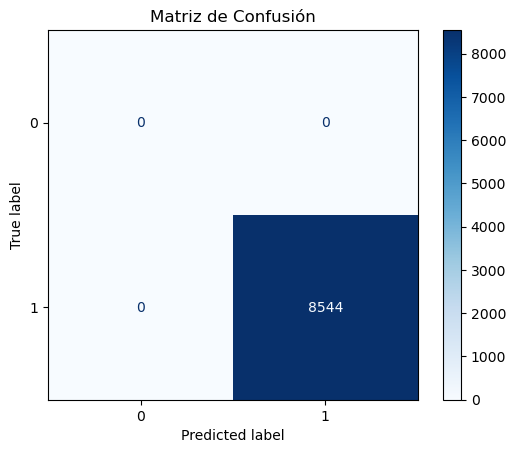

In [31]:
#Matriz de Confusión: Analiza la cantidad de predicciones correctas e incorrectas para cada clase.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def matriz_confusion(data_loader, model, all_labels):
    y_true = []
    y_pred = []
    model.eval()
    
    for data in data_loader:
        out = model(data)
        pred = out.argmax(dim=1)
        y_true.extend(data.y.numpy())
        y_pred.extend(pred.numpy())
    
    # Asegurar que se incluyan todas las etiquetas posibles
    cm = confusion_matrix(y_true, y_pred, labels=all_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_labels)
    disp.plot(cmap="Blues")
    plt.title("Matriz de Confusión")
    plt.show()

# Suponiendo que tus clases son 0 y 1
all_labels = [0, 1]
matriz_confusion(test_loader, model, all_labels)


In [36]:
#!pip install optuna
import optuna
def evaluar_modelo(model, data_loader):
    model.eval()  # Cambiar al modo evaluación
    correct = 0
    total = 0

    with torch.no_grad():  # No necesitamos gradientes aquí
        for data in data_loader:
            out = model(data)
            pred = out.argmax(dim=1)  # Predicción de la clase más probable
            correct += (pred == data.y).sum().item()  # Contar aciertos
            total += data.y.size(0)  # Total de ejemplos

    return correct / total  # Precisión

def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 16, 128)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    
    model = GCN(input_dim, hidden_dim, output_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Entrenamiento simple para evaluar
    for epoch in range(2):
        for data in train_loader:
            optimizer.zero_grad()
            out = model(data)
            loss = loss_fn(out, data.y)
            loss.backward()
            optimizer.step()
    
    # Evaluación del modelo
    accuracy = evaluar_modelo(model, test_loader)
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)
print("Mejores parámetros:", study.best_params)


[I 2024-12-03 16:36:45,506] A new study created in memory with name: no-name-5883f75c-31d4-4638-9dc7-e86f048b0886
/tmp/ipykernel_6407/2308938351.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-12-03 16:37:35,263] Trial 0 finished with value: 1.0 and parameters: {'hidden_dim': 123, 'learning_rate': 0.0003072947218955448}. Best is trial 0 with value: 1.0.
[I 2024-12-03 16:38:22,761] Trial 1 finished with value: 1.0 and parameters: {'hidden_dim': 26, 'learning_rate': 0.0013852386366461726}. Best is trial 0 with value: 1.0.
[I 2024-12-03 16:39:20,514] Trial 2 finished with value: 1.0 and parameters: {'hidden_dim': 75, 'learning_rate': 0.004105822424635378}. Best is trial 0 with value: 1.0.
[I 2024-12-03 16:45:31,247] Trial 3 finished with value: 1.0 

Mejores parámetros: {'hidden_dim': 123, 'learning_rate': 0.0003072947218955448}
